# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import poligrain as plg
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pypwsqc as pws

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
#read output data from FZ and HI filters
ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/HI_flagged_data_compressed.nc')

#slice to time of interest
ds_pws = ds_pws.sel(time = slice("2017-07-01 00:00","2017-08-01 00:00"))

In [215]:
ds_pws

<xarray.Dataset>
Dimensions:       (time: 8929, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude      (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude     (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.101 0.202 0.101 0.202 ... 0.0 0.0 0.0 0.0
    nbrs_not_nan  (id, time) float32 ...
    reference     (id, time) float64 ...
    hi_flag       (id, time) float32 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [158]:
#strict: including only stations that passed the FZ and HI test (fz_flag == 0, hi_flag == 0)
#setting 1 and -1 to NaN
filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag != 0, np.NaN).to_dataset() #this should be done for FZ flag as well!

#flex: including stations that passed the FZ and HI filters, and stations that do not have enough neighbours to apply the filters
#setting 1 to -NaN
#filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag == 1, np.NaN).to_dataset() 
filtered_rain

<xarray.Dataset>
Dimensions:    (time: 8929, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 0.101 0.202 0.101 0.202 ... nan nan nan nan

In [159]:
#load distance matrix
distance_matrix = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/distance_matrix.nc')
distance_matrix = distance_matrix.load()

#this renaming should be done before saving the distance matrix...r
distance_matrix = distance_matrix.rename({"__xarray_dataarray_variable__": "distance"})
distance_matrix

<xarray.Dataset>
Dimensions:      (id: 134, id_neighbor: 134)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Data variables:
    distance     (id, id_neighbor) float64 0.0 518.8 532.0 ... 4.265e+03 0.0

# Apply SO filter

In [214]:
#Set parameters
mint = 4032 
mrain = 100 
mmatch = 200
gamma = 0.15
beta = 0.2
nstat = 5

In [160]:
#Boolean 2D data array, defining neihbours within max_distance for all stations
max_distance = 10e3
neighbor_matrix = distance_matrix < max_distance
neighbor_matrix

<xarray.Dataset>
Dimensions:      (id: 134, id_neighbor: 134)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Data variables:
    distance     (id, id_neighbor) bool True True True True ... False True True

In [186]:
#nbrs = distance_matrix. < max_distance
test = distance_matrix.sel(id = "ams2").distance.where(distance_matrix.sel(id = "ams2").distance < 10e3, drop = True)
test

<xarray.DataArray 'distance' (id_neighbor: 24)>
array([ 518.79828487,    0.        ,  728.38027968, 4899.03185541,
       1857.13494281,  536.57331581,  628.2617951 , 1473.72603665,
       1517.54109781, 5942.40676644, 6308.69293054, 4838.52796437,
       5572.10632267, 9698.28833288, 5904.16094144, 9842.73461959,
       9399.69780323, 7856.26216578, 6581.41396432, 7920.92837158,
       8653.15773307, 7833.66556672, 8637.75503567, 9980.37990317])
Coordinates:
    id           <U6 'ams2'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams26' 'ams34'

In [ ]:
ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")

In [205]:
test2.id_neighbor.sizes 

Frozen({'id_neighbor': 24})

In [199]:
#indicies of stations within max_range
test2 = distance_matrix.sel(id = "ams2").distance.where(distance_matrix.sel(id = "ams2").distance < max_distance, drop = True).id_neighbor
test2

<xarray.DataArray 'id_neighbor' (id_neighbor: 24)>
array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15', 'ams16', 'ams17',
       'ams19', 'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams34'],
      dtype='<U6')
Coordinates:
    id           <U6 'ams2'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams26' 'ams34'

In [ ]:
# Default Bias Correction Factor
dbc = 1

In [192]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = filtered_rain > 0 
rainy_timesteps

<xarray.Dataset>
Dimensions:    (time: 8929, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) bool True True True True ... False False False False

In [68]:
#Number of cumulative rainy timesteps per station
cum_rainy_timesteps = np.cumsum(rainy_timesteps)

In [213]:
neighbors.sizes["id_neighbor"]

25

In [233]:
rainy_timesteps

<xarray.Dataset>
Dimensions:    (time: 8929, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) bool True True True True ... False False False False

In [198]:
#rainy_timesteps.rainfall.where(rainy_timesteps.rainfall == True).sel(id = "ams13")
evaluation_period_end

4032

In [197]:
rainy_timesteps.sel(id = test2).isel(time = slice(evaluation_period_start, evaluation_period_end))

<xarray.Dataset>
Dimensions:      (time: 4031, id_neighbor: 24)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-01T00:05:00 ... 2017-07-14T23:...
    id           (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams26' 'ams34'
    elevation    (id_neighbor) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    latitude     (id_neighbor) float64 52.31 52.3 52.31 ... 52.28 52.28 52.28
    longitude    (id_neighbor) float64 4.671 4.675 4.677 ... 4.783 4.795 4.816
    x            (id_neighbor) float64 2.049e+05 2.052e+05 ... 2.146e+05
    y            (id_neighbor) float64 5.804e+06 5.803e+06 ... 5.8e+06 5.8e+06
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams26' 'ams34'
Data variables:
    rainfall     (id_neighbor, time) bool True True True ... False False False

In [253]:
so_flag = np.empty((ds_pws.sizes["id"], ds_pws.sizes["time"]))
np.shape(so_flag)

(134, 8929)

In [251]:
#ds_pws.sizes["id"]
ds_pws.sizes["id"]

8929

In [231]:
ds_pws['foo'] = ds_pws.rainfall.copy()
ds_pws.foo[0, 1] = 33
ds_pws.foo

<xarray.DataArray 'foo' (id: 134, time: 8929)>
array([[ 0.101, 33.   ,  0.101, ...,  0.   ,  0.   ,  0.   ],
       [ 0.101,  0.202,  0.202, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.202,  0.202,  0.202, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.101,  0.202, ...,  0.   ,  0.   ,  0.   ],
       [ 0.202,  0.101,  0.202, ...,  0.   ,  0.   ,  0.   ]])
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

In [254]:
so_flag = np.empty((ds_pws.sizes["id"], ds_pws.sizes["time"]))
np.shape(so_flag)

(134, 8929)

In [259]:
filtered_rain.sizes["id" ]

134

In [263]:
filtered_rain.id.data

array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8',
       'ams9', 'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15',
       'ams16', 'ams17', 'ams18', 'ams19', 'ams20', 'ams21', 'ams22',
       'ams23', 'ams24', 'ams25', 'ams26', 'ams27', 'ams28', 'ams29',
       'ams30', 'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36',
       'ams37', 'ams38', 'ams39', 'ams40', 'ams41', 'ams42', 'ams43',
       'ams44', 'ams45', 'ams46', 'ams47', 'ams48', 'ams49', 'ams50',
       'ams51', 'ams52', 'ams53', 'ams54', 'ams55', 'ams56', 'ams57',
       'ams58', 'ams59', 'ams60', 'ams61', 'ams62', 'ams63', 'ams64',
       'ams65', 'ams66', 'ams67', 'ams68', 'ams69', 'ams70', 'ams71',
       'ams72', 'ams73', 'ams74', 'ams75', 'ams76', 'ams77', 'ams78',
       'ams79', 'ams80', 'ams81', 'ams82', 'ams83', 'ams84', 'ams85',
       'ams86', 'ams87', 'ams88', 'ams89', 'ams90', 'ams91', 'ams92',
       'ams93', 'ams94', 'ams95', 'ams96', 'ams97', 'ams98', 'ams99',
       'ams100', 'am

In [257]:
so_flag[station_id, timestep] = -1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [264]:
%%time
#initalize with empty numpy array ---> are there empty entries in the end? or -999 
#so_flag = np.empty((ds_pws.sizes["id"], ds_pws.sizes["time"]))

match_list = []
for station_id in filtered_rain.id.data: #range(0, filtered_rain.sizes["id" ])
    # one bias correction factor per station, which will be updated at the end of this code block
    BCF_prev = dbc

    #use the below for variable evaluation period
    #cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")
    for timestep in range(mint, mint+1):#ds_pws.sizes["time"]): 
        
        #fixed evaluation period for now
        evaluation_period_start = timestep - mint + 1
        evaluation_period_end = timestep

        #pick neighbors within max_distance, exclude station itself (where distance is zero)
        nbrs_within_range = (distance_matrix.sel(id = station_id).distance < max_distance) & (distance_matrix.sel(id = station_id).distance > 0)
        
        #pick neighbors ids
        neighbors = distance_matrix.sel(id = station_id).distance.where(nbrs_within_range, drop = True).id_neighbor

        #if less than nstat neighbors within max_distance
        # if there are not enough stations nearby or no observations in 'Nint',!!!!
        #if neighbors.sizes["id_neighbor"] < nstat:
            #ds_pws["so_flag"] = -1

        #pick rainy timesteps within evaulation period for this station
        #posrain = np.where(idx_posrain[idx_rain_start:idx_rain_end, i] == 1)[0]
        
        rainy_timestep = rainy_timesteps.sel(id = neighbors).isel(time = slice(evaluation_period_start, evaluation_period_end))

        matches = rainy_timestep.sum()
        
        #matches = np.sum(idx_posrain[posrain, neighbors])
        match_list.append(matches)

        #if matches < mmatch: filter cannot be applied
        #ds_pws["so_flag"] = -1 
        #SOfilter[k, i] = -1

CPU times: total: 1.97 s
Wall time: 1.96 s


In [243]:
match_list

[<xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2043,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2126,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2327,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2145,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2692,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 1978,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2033,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2133,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2168,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 1818,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 1818,
 <xarray.Dataset>
 Dimensions:   ()
 Data variables:
     rainfall  int32 2011,
 <xarray.Dataset>
 Dimensions:   ()
 Dat

In [224]:
rainy_timestep = rainy_timesteps.sel(id = neighbors).isel(time = slice(evaluation_period_start, evaluation_period_end))
rainy_timestep

<xarray.Dataset>
Dimensions:      (time: 4031, id_neighbor: 25)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-01T00:05:00 ... 2017-07-14T23:...
    id           (id_neighbor) <U6 'ams89' 'ams90' 'ams92' ... 'ams133' 'ams134'
    elevation    (id_neighbor) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    latitude     (id_neighbor) float64 52.29 52.29 52.3 ... 52.31 52.3 52.26
    longitude    (id_neighbor) float64 4.907 4.907 4.909 ... 5.032 5.041 5.045
    x            (id_neighbor) float64 2.209e+05 2.209e+05 ... 2.301e+05
    y            (id_neighbor) float64 5.801e+06 5.801e+06 ... 5.798e+06
  * id_neighbor  (id_neighbor) <U6 'ams89' 'ams90' 'ams92' ... 'ams133' 'ams134'
Data variables:
    rainfall     (id_neighbor, time) bool False False False ... False False

In [226]:
rainy_timestep.sum(dim = "time")

<xarray.Dataset>
Dimensions:      (id_neighbor: 25)
Coordinates:
    id           (id_neighbor) <U6 'ams89' 'ams90' 'ams92' ... 'ams133' 'ams134'
    elevation    (id_neighbor) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan'
    latitude     (id_neighbor) float64 52.29 52.29 52.3 ... 52.31 52.3 52.26
    longitude    (id_neighbor) float64 4.907 4.907 4.909 ... 5.032 5.041 5.045
    x            (id_neighbor) float64 2.209e+05 2.209e+05 ... 2.301e+05
    y            (id_neighbor) float64 5.801e+06 5.801e+06 ... 5.798e+06
  * id_neighbor  (id_neighbor) <U6 'ams89' 'ams90' 'ams92' ... 'ams133' 'ams134'
Data variables:
    rainfall     (id_neighbor) int32 0 109 0 0 116 0 0 ... 71 122 0 0 0 110 115

In [ ]:
                r_values = np.zeros(len(neighbors))
                bias_values = np.zeros(len(neighbors))
                for j in range(len(neighbors)): 
                    # correlation for certain length of rain event between station and one neigbor
                    r = np.corrcoef(
                        netatmo_hour[evaluation_period_start:idx_rain_end, i], 
                        netatmo_hour[evaluation_period_start:idx_rain_end, neighbors[j]],
                    )                 
                    r_values[j] = r[0, 1]
                    # time of the difference in that event
                    deltaR = (
                        netatmo_hour[evaluation_period_start:idx_rain_end, i] 
                        - netatmo_hour[evaluation_period_start:idx_rain_end, neighbors[j]]
                    )
                    # diff / rain_value_neibor
                    bias = np.nanmean(deltaR) / np.nanmean(netatmo_hour[idx_rain_start:idx_rain_end, neighbors[j]])
                    bias_values[j] = bias
                med_r = np.median(r_values) # median PCC off PCCs with all neighbors
                # if the correlation with neighbors is large enough, we calculate a new bias correction factor
                if med_r > gamma:
                    bias_values[np.isinf(bias_values)] = np.nan
                    med_bias = np.nanmedian(bias_values) # median of bias of indivial bias to all neigbors
                    BCFnew = 1 / (1 + med_bias)
                    if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                        BCF_prev = BCFnew
                # if PCC is too low, then it is a "station outlier"
                else:
                    #SOfilter[k, i] = 1
                    #ds_pws["so_flag"] = 1 
            BCF[k, i] = BCF_prev
        toc(tt2)
    np.savez_compressed(sofile, SOfilter=SOfilter)
    np.savez_compressed(bcffile, BCF=BCF)

# Gammal kod nedan

In [ ]:
# Default Bias Correction
dbc = 1
# SO filter

rain_fz_hi_flagged = ds_pws.rainfall.where(ds_pws.hi_flag != -1, np.NaN).data.T
#SOfilter = FZfilter
#SOfilter[:, :] = 0
SOfilter = np.zeros_like(rain_fz_hi_flagged)
BCF = np.ones_like(SOfilter)*dbc
#BCF = SOfilter
#BCF[:, :] = dbc
mint = 4032
mrain = 100 #den här variabeln ger ett "minne" till systemet. För ams115 så ger mrain =100 att det först är till-
#räckligt med tidssteg för att ha fixed time window (för det har regnat mycket) men mot slutet av perioden är
#m = 100 inte tillräckligt längre (för det har inte regnat på ett tag)
mmatch = 200
gamma = 0.15
beta = 0.2

In [41]:
%%time

#for i in range(3, 9):#rain_fz_hi_flagged.shape[1]): # loop over sensor id
length_list = []
for i in range(114, 115):#rain_fz_hi_flagged.shape[1]): # loop over sensor id
    #print(i)
    # one bias correction factor per station, which will be updated at the end of this code block
    BCF_prev = dbc
    cum_raintime = np.cumsum(idx_posrain[:, i]) #antal regniga tidssteg för denna station, ackumulerat PER TIDSSTEG. Så detta är inte
    #bara för aktuellt tidssteg (Ett värde) utan det är ett värde för hela tidsserien. 
    #För station ams115; 257 regniga tidssteg under juli 2017.
    
    #loopen nedan går snabbt för en månad men supersegt för två år
    for k in range(mint, rain_fz_hi_flagged.shape[0]): # loop over time
    #print(k)
        if cum_raintime[k] - cum_raintime[k - mint + 1] >= mrain:
            #looking at the station itself, its own time series
            #fixed window length (mint time steps long)
            #print('there ARE at least mrain rainy timesteps within the last mint timesteps', k)
            idx_rain_start = k - mint + 1
            #print('so the start of the evaluation period is', idx_rain_start)
            idx_rain_end = k
            #print('and the end of the evaluation period is', idx_rain_end)
        else:
            # move start index far enough back in time so that we have mrain rainy time steps
            #print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps', k)
            if cum_raintime[k] - mrain >= 0:
                idx_rain_start = np.where(cum_raintime == (cum_raintime[k] - mrain))[0][0]
                #print('so the start of the evaluation period is', idx_rain_start)
                idx_rain_end = k
                #print('so the lenght of the evaluation period is', idx_rain_end-idx_rain_start)
                
        length_list.append(idx_rain_end - idx_rain_start)


CPU times: total: 2.45 s
Wall time: 2.53 s


# Cell below starts implementation with variable evaluation period - halting this

In [20]:
%%time

length_list = []
for station_id in filtered_rain.id.data: 
    # one bias correction factor per station, which will be updated at the end of this code block
    BCF_prev = dbc
    cum_rainy_timestepss = rainy_timesteps.cumsum(dim="time")
    for timestep in range(mint, ds_pws.dims["time"]): 

        #perhaps skip the below
        if cum_rainy_timestepss[timestep] - cum_rainy_timestepss[timestep - mint + 1] >= mrain:
            print('there ARE at least mrain rainy timesteps within the last mint timesteps', timestep)
            evaluation_period_start = timestep - mint + 1
            evaluation_period_end = timestep
        else:
            print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps', k)
            if cum_rainy_timestepss[timestep] - mrain >= 0:
                evaluation_period_start = np.where(cum_rainy_timestepss == (cum_rainy_timestepss[timestep] - mrain))[0][0]
                #print('so the start of the evaluation period is', idx_rain_start)
                evaluation_period_end = timestep
                #print('so the lenght of the evaluation period is', idx_rain_end-idx_rain_start)
                
        length_list.append(evaluation_period_end - evaluation_period_start)

C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


IndexError: index 4032 is out of bounds for axis 0 with size 134

Text(0.5, 1.0, 'Ams115: length of evaluation period')

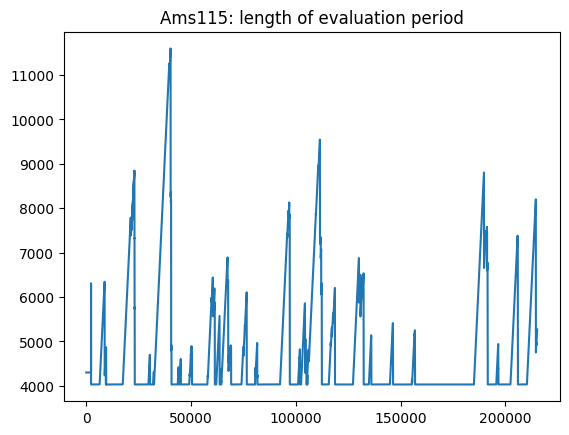

In [52]:
plt.plot(length_list)
plt.title("Ams115: length of evaluation period")
#in the beginning of july it was raining so there enough time steps. But then it has been dry for a while so the 
#algorithm must go further and further back in time to find enough time steps. It will do so until it rains
#for a while again"

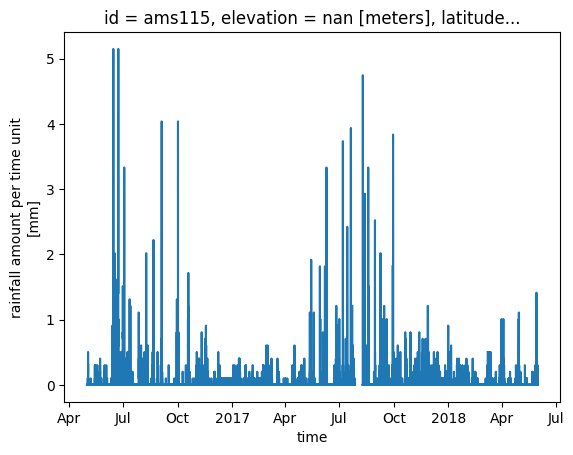

In [51]:
ds_pws.rainfall.sel(id="ams115").plot()

Text(0.5, 1.0, 'Nr of rainy timesteps for station ams115 for the whole period')

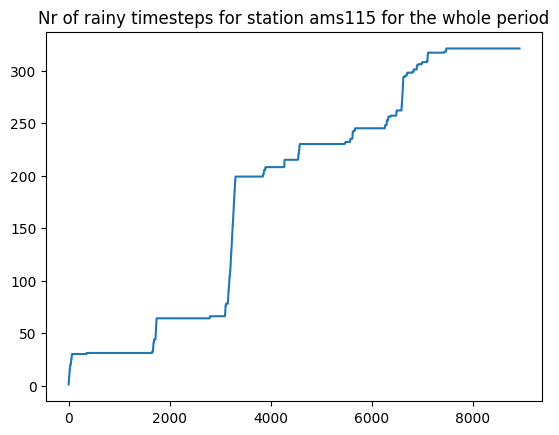

In [47]:
#fig, axs = plt.subplot()
plt.plot(cum_raintime)
#plt.plot(rain_fz_hi_flagged[7])
plt.title("Nr of rainy timesteps for station ams115 for the whole period")

In [ ]:
#for i in range(3, 9):#rain_fz_hi_flagged.shape[1]): # loop over sensor id
for i in range(7, 8):#rain_fz_hi_flagged.shape[1]): # loop over sensor id
    print(i)
    # one bias correction factor per station, which will be updated at the end of this code block
    BCF_prev = dbc
    cum_raintime = np.cumsum(idx_posrain[:, i])

    filter_is_applicable_list = []
    matches_list = []
    window_length_list = []
    
    for k in range(mint, rain_fz_hi_flagged.shape[0]): # loop over time
        # What exaxtly is this doing?
        # mrain = 100 (in Lotte's paper), threshold for minimum number of non-zero rainfall
        # mint = 4032, taken from Lottes paper which works with 5-minute data, i.e. mint = two weeks
        filter_is_applicable = True
        #statement below defines lenght of window to be evaluatied
        if cum_raintime[k] - cum_raintime[k - mint + 1] >= mrain:
            print('there ARE at least mrain rainy timesteps within the last mint timesteps')
            idx_rain_start = k - mint + 1
            print('so the start of the evaluation period is', idx_rain_start)
            idx_rain_end = k
            print('and the end of the evaluation period is', idx_rain_end)
        else:
            # move start index far enough back in time so that we have mrain rainy time steps
            print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps')
            if cum_raintime[k] - mrain >= 0:
                idx_rain_start = np.where(cum_raintime == (cum_raintime[k] - mrain))[0][0]
                idx_rain_end = k
            else:
                filter_is_applicable = False

        window_length_list.append(idx_rain_end - idx_rain_start)
        
        filter_is_applicable_list.append(filter_is_applicable)
        
        if filter_is_applicable:
            neighbors = np.where(idx_dist[:, i] > 0)[0] #exclude station itself
            #neighbors = np.where(idx_dist[:, i] == True)[0]
            posrain = np.where(idx_posrain[idx_rain_start:idx_rain_end, i] == 1)[0]
            matches = np.sum(idx_posrain[:, neighbors][posrain, :])
        else:
            SOfilter[k, i] = -1
            continue
            
        # not apply SO if not nstat stations with mmatch intervals
        matches_list.append(matches)
        if matches < mmatch:
            SOfilter[k, i] = -1
        else:
            r_values = np.zeros(len(neighbors))
            bias_values = np.zeros(len(neighbors))
            for j in range(len(neighbors)): 
                # correlation for certain length of rain event between station and one neigbor
                r = np.corrcoef(
                    rain_fz_hi_flagged[idx_rain_start:idx_rain_end, i], 
                    rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]],
                )                 
                r_values[j] = r[0, 1]
                # time of the difference in that event
                deltaR = (
                    rain_fz_hi_flagged[idx_rain_start:idx_rain_end, i] 
                    - rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]]
                )
                # diff / rain_value_neibor
                bias = np.nanmean(deltaR) / np.nanmean(rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]])
                bias_values[j] = bias
            med_r = np.median(r_values) # median PCC off PCCs with all neighbors
            # if the correlation with neighbors is large enough, we calculate a new bias correction factor
            if med_r > gamma:
                bias_values[np.isinf(bias_values)] = np.nan
                med_bias = np.nanmedian(bias_values) # median of bias of indivial bias to all neigbors
                BCFnew = 1 / (1 + med_bias)
                if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                    BCF_prev = BCFnew
            # if PCC is too low, then it is a "station outlier"
            else:
                SOfilter[k, i] = 1
        BCF[k, i] = BCF_prev
    #toc(tt2)
#np.savez_compressed(sofile, SOfilter=SOfilter)
#np.savez_compressed(bcffile, BCF=BCF)

7
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this


C:\Users\a002461\AppData\Local\Temp\ipykernel_460\511465557.py:87: RuntimeWarning: Mean of empty slice
  bias = np.nanmean(deltaR) / np.nanmean(netatmo_hour[idx_rain_start:idx_rain_end, neighbors[j]])
C:\Users\a002461\AppData\Local\Temp\ipykernel_460\511465557.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  bias = np.nanmean(deltaR) / np.nanmean(netatmo_hour[idx_rain_start:idx_rain_end, neighbors[j]])


this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this
this


In [234]:
len(matches_list)

4897

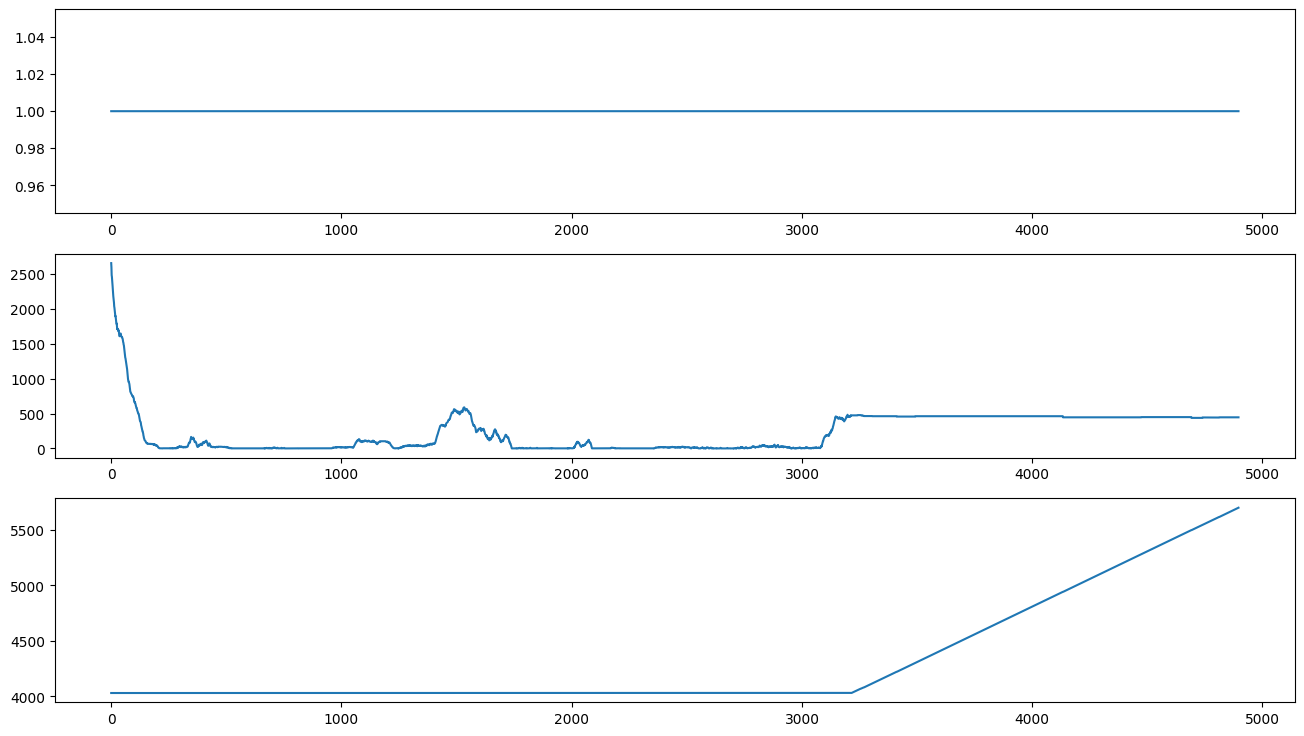

In [228]:
fig, axs = plt.subplots(3, 1, figsize=(16, 9))
axs[0].plot(filter_is_applicable_list)
axs[1].plot(matches_list)
axs[2].plot(window_length_list)

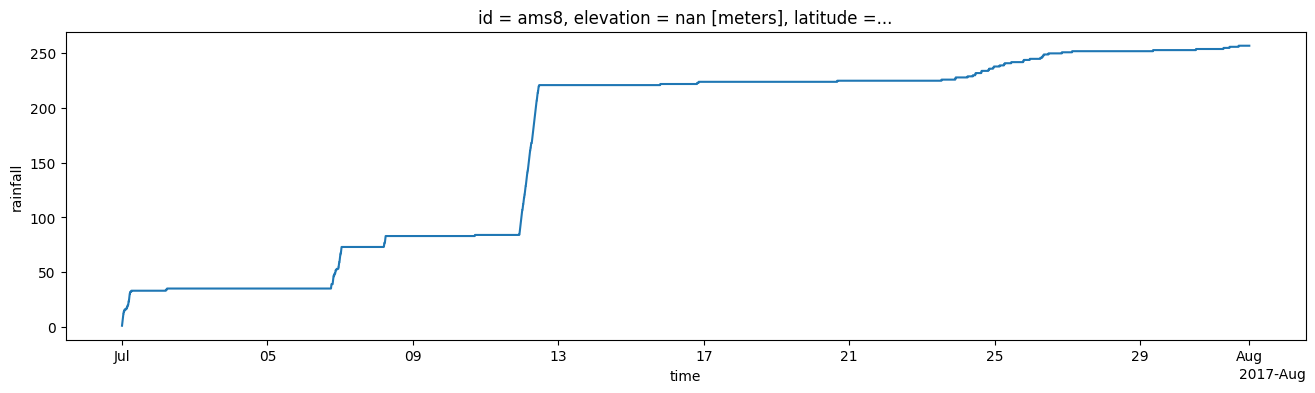

In [256]:
(ds_pws.isel(id=7).rainfall > 0).where(ds_pws.isel(id=7).hi_flag != -1, np.NaN).cumsum(dim='time').plot(figsize=(16, 4))

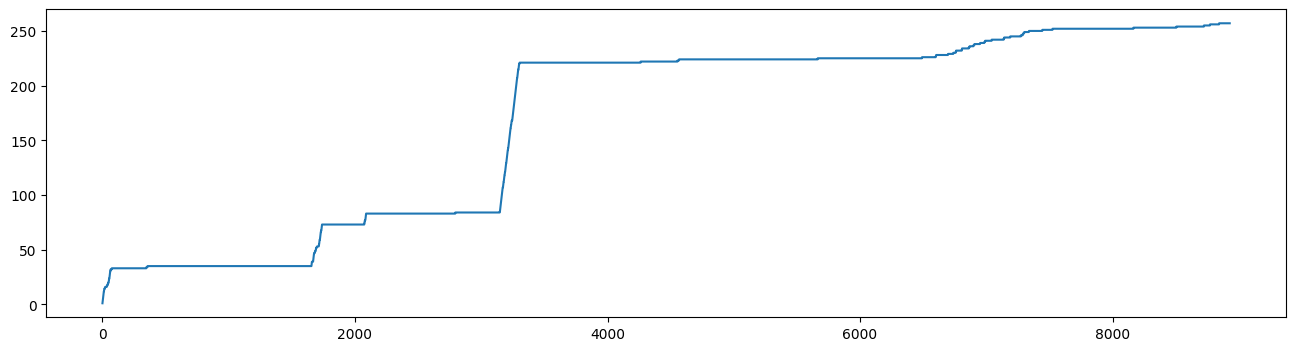

In [239]:
fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(cum_raintime)

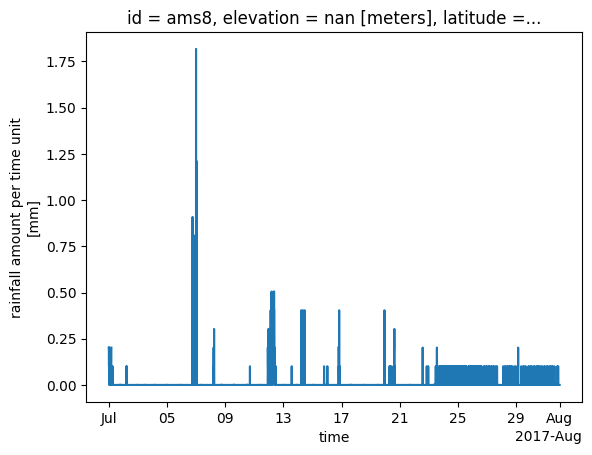

In [249]:
ds_pws.isel(id=7).rainfall.plot()

In [253]:
#rain_fz_hi_flagged = ds_pws.rainfall.where(ds_pws.hi_flag != -1, np.NaN).data
#plt.plot(rain_fz_hi_flagged[i, :])

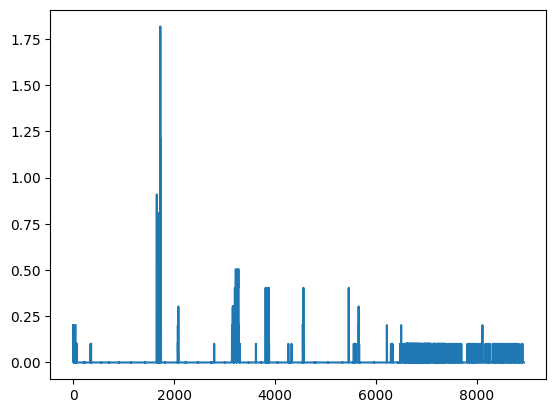

In [254]:
rain_fz_hi_flagged = ds_pws.rainfall.data.T
plt.plot(rain_fz_hi_flagged[:, i])

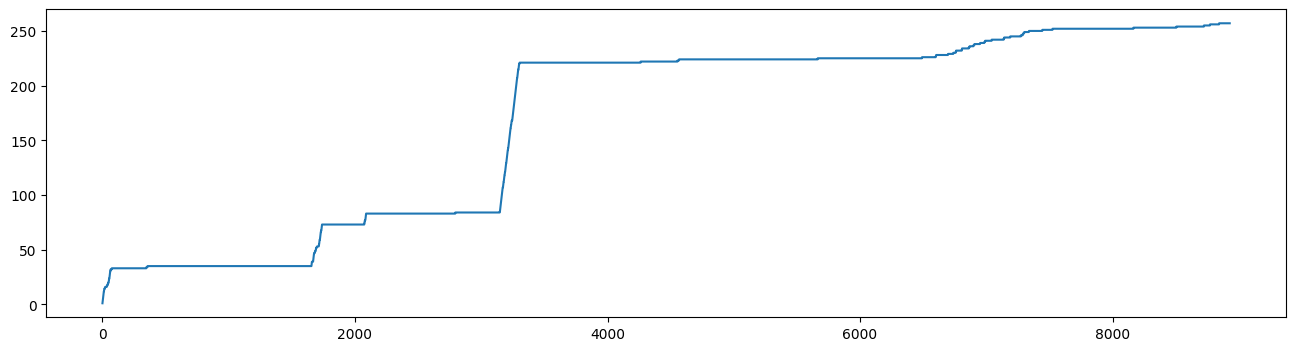

In [247]:
idx_posrain = rain_fz_hi_flagged > 0 # 2D array (id, time) of rainfall values
#idx_posrain[:, :] = idx_posrain[:, :] > 0

i = 7
cum_raintime = np.cumsum(idx_posrain[:, i])

fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(cum_raintime)

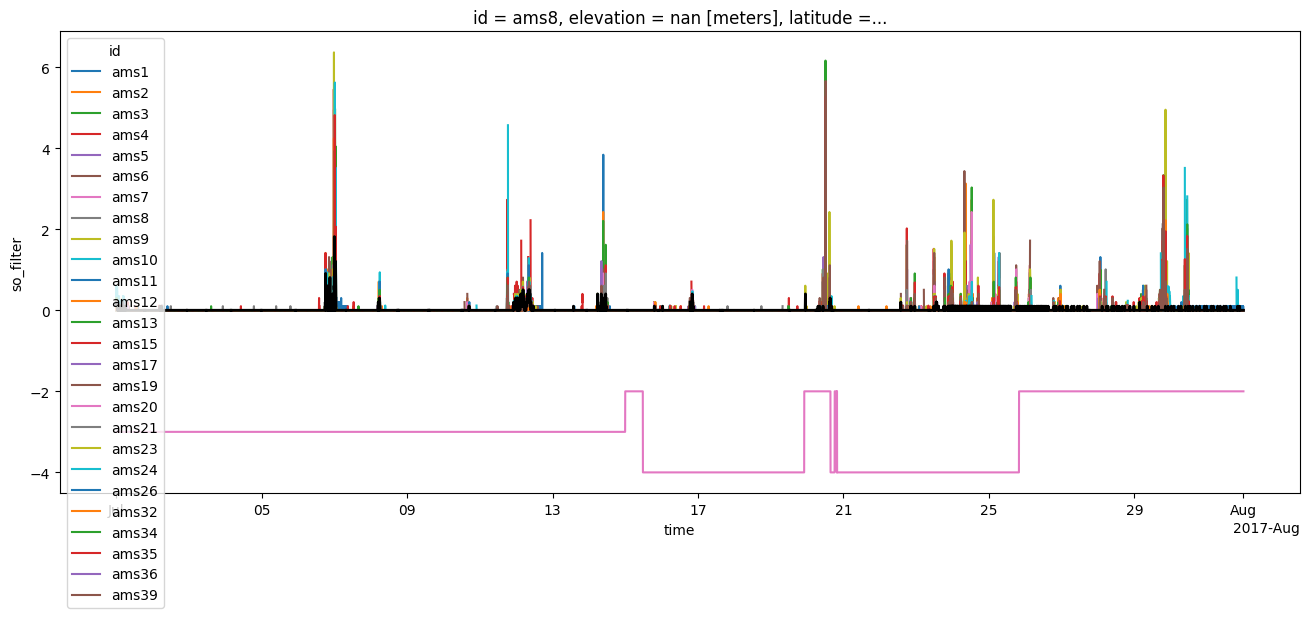

In [257]:
ds_pws['so_filter'] = (('time', 'id'), df_result)

ds_pws.isel(id=neighbors).rainfall.plot.line(x='time', figsize=(16, 6));
ds_pws.isel(id=7).rainfall.plot(c='k', linewidth=2);
(ds_pws.isel(id=7).so_filter - 3).plot();

#(ds_pws.isel(id=7).rainfall > 0).cumsum(dim='time').plot();
 #np.cumsum(idx_posrain[:, i])

#(ds_pws.isel(id=neighbors).rainfall > 0).sum(dim='id').plot();
#(ds_pws.isel(id=neighbors).rainfall > 0).sum(dim='id').rolling(time=mint).sum().plot();

#np.sum(idx_posrain[:, neighbors][posrain, :])

In [201]:
SOfilter2 = SOfilter

In [202]:
df_result = pd.DataFrame(SOfilter2)
df_result

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
so_df

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
2017-07-01 00:00:00,0,0,0,1,0,0,0,0,0,-1,...,0,1,0,0,-1,-1,-1,0,0,1
2017-07-01 00:05:00,0,0,0,1,0,0,0,0,0,-1,...,0,1,0,0,-1,-1,-1,0,0,1
2017-07-01 00:10:00,0,0,0,1,0,0,0,0,0,-1,...,0,1,0,0,-1,-1,-1,0,0,1
2017-07-01 00:15:00,0,0,0,1,0,0,0,0,0,-1,...,0,1,0,0,-1,-1,-1,0,0,1
2017-07-01 00:20:00,0,0,0,1,0,0,0,0,0,-1,...,0,1,0,0,-1,-1,-1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:40:00,0,0,0,0,0,0,0,1,0,-1,...,0,0,0,0,-1,-1,-1,0,0,0
2017-07-31 23:45:00,0,0,0,0,0,0,0,1,0,-1,...,0,0,0,0,-1,-1,-1,0,0,0
2017-07-31 23:50:00,0,0,0,0,0,0,0,1,0,-1,...,0,0,0,0,-1,-1,-1,0,0,0
2017-07-31 23:55:00,0,0,0,0,0,0,0,1,0,-1,...,0,0,0,0,-1,-1,-1,0,0,0


<Axes: >

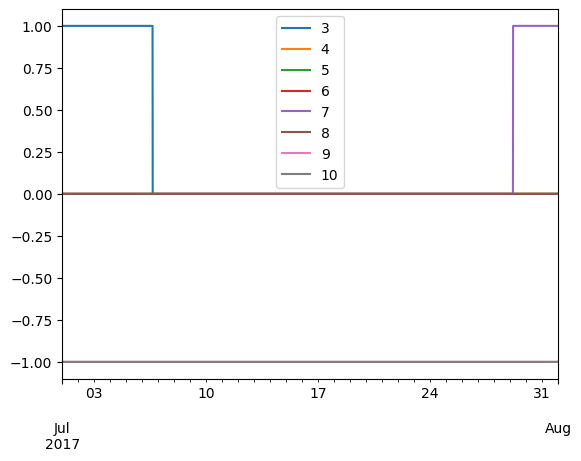

In [189]:
so_df.loc[:, 3:10].plot()

<Axes: >

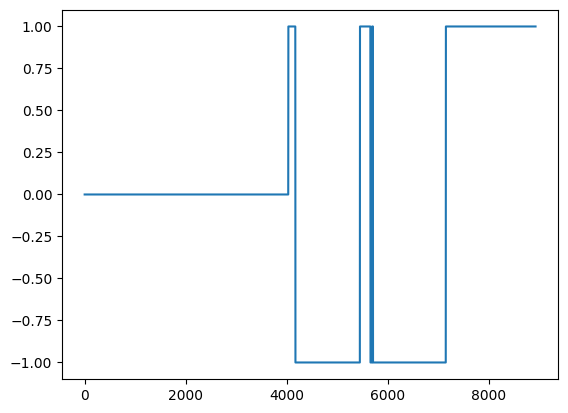

In [203]:
df_result.loc[:, 7].plot()

In [136]:
import pandas as pd
so_df = pd.read_csv('C:/Users/a002461/OPENSENSE/data/SO_flags_AMSdataset.csv', header = None)

so_df.index = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/HI_flagged_data_compressed.nc').time
so_df = so_df.loc[ds_pws.time.data, :]


In [150]:
so_df.loc[:, 0:3]

,0,1,2,3
2017-07-01 00:00:00,0,0,0,1
2017-07-01 00:05:00,0,0,0,1
2017-07-01 00:10:00,0,0,0,1
2017-07-01 00:15:00,0,0,0,1
2017-07-01 00:20:00,0,0,0,1
...,...,...,...,...
2017-07-31 23:40:00,0,0,0,0
2017-07-31 23:45:00,0,0,0,0
2017-07-31 23:50:00,0,0,0,0
2017-07-31 23:55:00,0,0,0,0


In [163]:
SOfilter[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Default Bias Correction
dbc = 1
# SO filter
tt = time.time()
if not os.path.isfile(sofile):
    SOfilter = FZfilter
    SOfilter[:, :] = 0
    BCF = SOfilter
    BCF[:, :] = dbc
    idx_posrain = rain_fz_hi_flagged # 2D array (id, time) of rainfall values
    idx_posrain[:, :] = idx_posrain[:, :] > 0
    for i in range(rain_fz_hi_flagged.shape[1]): # loop over sensor id
        tt2 = time.time()
        # one bias correction factor per station, which will be updated at the end of this code block
        BCF_prev = dbc
        cum_raintime = np.cumsum(idx_posrain[:, i])
        for k in range(mint, rain_fz_hi_flagged.shape[0]): # loop over time
            # IMO this is mainly doing a rolling PCC and a rolling bias
            # ...
            #
            if time.time() - tt > 10: # every now and then print some info
                tt = time.time()
                print('Station:', i, 'af 1635, Tidsskridt:', k, 'af 10995')
            # What exaxtly is this doing?
            # mrain = 100 (in Lotte's paper), threshold for minimum number of non-zero rainfall
            # mint = 4032, taken from Lottes paper which works with 5-minute data, i.e. mint = two weeks
            if cum_raintime[k] - cum_raintime[k - mint + 1] >= mrain:
                idx_rain_start = k - mint + 1
                idx_rain_end = k
            else:
                # move start index far enough back in time so that we have mrain rainy time steps
                idx_rain_start = np.where(cum_raintime == (cum_raintime[k] - mrain))[0][0]
                idx_rain_end = k
            neighbors = np.where(idx_dist[:, i] > 0)[0]
            posrain = np.where(idx_posrain[idx_rain_start:idx_rain_end, i] == 1)[0]
            matches = np.sum(idx_posrain[posrain, neighbors])
            # not apply SO if not nstat stations with mmatch intervals
            if matches < mmatch:
                SOfilter[k, i] = -1
            else:
                r_values = np.zeros(len(neighbors))
                bias_values = np.zeros(len(neighbors))
                for j in range(len(neighbors)): 
                    # correlation for certain length of rain event between station and one neigbor
                    r = np.corrcoef(
                        rain_fz_hi_flagged[idx_rain_start:idx_rain_end, i], 
                        rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]],
                    )                 
                    r_values[j] = r[0, 1]
                    # time of the difference in that event
                    deltaR = (
                        rain_fz_hi_flagged[idx_rain_start:idx_rain_end, i] 
                        - rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]]
                    )
                    # diff / rain_value_neibor
                    bias = np.nanmean(deltaR) / np.nanmean(rain_fz_hi_flagged[idx_rain_start:idx_rain_end, neighbors[j]])
                    bias_values[j] = bias
                med_r = np.median(r_values) # median PCC off PCCs with all neighbors
                # if the correlation with neighbors is large enough, we calculate a new bias correction factor
                if med_r > gamma:
                    bias_values[np.isinf(bias_values)] = np.nan
                    med_bias = np.nanmedian(bias_values) # median of bias of indivial bias to all neigbors
                    BCFnew = 1 / (1 + med_bias)
                    if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                        BCF_prev = BCFnew
                # if PCC is too low, then it is a "station outlier"
                else:
                    SOfilter[k, i] = 1
            BCF[k, i] = BCF_prev
        toc(tt2)
    np.savez_compressed(sofile, SOfilter=SOfilter)
    np.savez_compressed(bcffile, BCF=BCF)
else:
    data = np.load(sofile)
    SOfilter = data['SOfilter']
    data = np.load(bcffile)
    BCF = data['BCF']